## Question 2

## Question 3

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2
import numpy as np
import os
from torchvision import transforms

# Configuration
CFG = {
    "clip_length": 16,       # Number of frames per clip
    "resize_shape": (112, 112), 
    "batch_size": 8,
    "num_workers": 4,
    "num_epochs": 20,
    "num_classes": 11,
    "lr": 3e-4,
}

# Custom Dataset Class
class VideoDataset(Dataset):
    def __init__(self, csv_path, mode='train'):
        self.df = pd.read_csv(csv_path)
        self.mode = mode
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        video_path = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]
        
        # Read video frames
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, CFG['resize_shape'])
            frames.append(frame)
        cap.release()
        
        # Convert to numpy array
        frames = np.array(frames)
        
        # Sample or pad clips
        clips = self.process_clips(frames)
        
        # Apply transforms and return
        clips_tensor = torch.stack([self.transforms(clip) for clip in clips])
        return clips_tensor.permute(1, 0, 2, 3), label  # (C, T, H, W)

    def process_clips(self, frames):
        # Pad if video is shorter than clip length
        if len(frames) < CFG['clip_length']:
            pad = np.zeros((CFG['clip_length'] - len(frames), *frames.shape[1:]))
            frames = np.concatenate([frames, pad], axis=0)
        
        # Extract sliding window clips
        clips = []
        for i in range(0, len(frames), CFG['clip_length']):
            clip = frames[i:i+CFG['clip_length']]
            if len(clip) == CFG['clip_length']:
                clips.append(clip)
        
        return clips[:1]  # Return first clip only for simplicity

# 3D CNN Model
class Conv3DModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
            
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, CFG['num_classes'])
        )

    def forward(self, x):
        # x shape: (B, C, T, H, W)
        x = self.conv_layers(x)
        return self.classifier(x)

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Conv3DModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=CFG['lr'])
criterion = nn.CrossEntropyLoss()

# Data Loaders
train_dataset = VideoDataset('data/train_map.csv', mode='train')
train_loader = DataLoader(train_dataset, batch_size=CFG['batch_size'],
                         shuffle=True, num_workers=CFG['num_workers'])

test_dataset = VideoDataset('data/test_map.csv', mode='test')
test_loader = DataLoader(test_dataset, batch_size=CFG['batch_size'],
                        shuffle=False, num_workers=CFG['num_workers'])

# Training Loop
for epoch in range(CFG['num_epochs']):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch+1}/{CFG["num_epochs"]} Loss: {epoch_loss:.4f}')

# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77318932d6c0>
Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_125280/1920668994.py", line 59, in __getitem__
    clips_tensor = torch.stack([self.transforms(clip) for clip in clips])
                                ^^^^^^^^^^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torchvision/transforms/transforms.py", line 137, in __call__
    return F.to_tensor(pic)
           ^^^^^^^^^^^^^^^^
  File "/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torchvision/transforms/functional.py", line 145, in to_tensor
    raise ValueError(f"pic should be 2/3 dimensional. Got {pic.ndim} dimensions.")
ValueError: pic should be 2/3 dimensional. Got 4 dimensions.


In [ ]:
test_dataset = VideoDataset('data/test_map.csv', mode='test')
test_dataset[0]

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

## Question 4

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import os  # Import os for directory handling

# Hyperparameters
SEQUENCE_LENGTH = 16
BATCH_SIZE = 32
NUM_EPOCHS = 30
HIDDEN_SIZE = 512
NUM_CLASSES = 11
LEARNING_RATE = 0.001

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create runs directory for saving models
os.makedirs('runs', exist_ok=True)

# Video Dataset class (unchanged)
class VideoDataset(Dataset):
    def __init__(self, csv_file, transform=None, seq_length=16):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        # Read video and extract frames
        frames = self.extract_frames(video_path)
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])

        return frames, label

    def extract_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []
        
        try:
            if frame_count >= self.seq_length:
                # Take continuous clip from middle of the video
                start_idx = max(0, (frame_count - self.seq_length) // 2)
                indices = range(start_idx, start_idx + self.seq_length)
            else:
                # Take all available frames and pad with zeros
                indices = range(frame_count)
            
            # Read actual frames
            for idx in indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, (224, 224))  # Pre-resize here
                    frames.append(frame)
            
            # Pad with zeros if needed
            while len(frames) < self.seq_length:
                frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
                
        finally:
            cap.release()
        
        return np.array(frames[:self.seq_length])  # Ensure exact sequence length

# CNN-LSTM Model (unchanged)
class CNNLSTM(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(CNNLSTM, self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(2048, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        c_in = x.view(batch_size * seq_len, c, h, w)
        c_out = self.resnet(c_in)
        c_out = c_out.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(c_out)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output

# Data preprocessing (unchanged)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and split data
full_train_dataset = VideoDataset('data/train_map.csv', transform=transform, seq_length=SEQUENCE_LENGTH)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model, criterion, optimizer (unchanged)
model = CNNLSTM(HIDDEN_SIZE, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_accuracy = 0.0  # Track best validation accuracy

from tqdm import tqdm

# Modified training loop with tqdm and ETA
best_accuracy = 0.0
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    total_loss = 0
    train_bar = tqdm(enumerate(train_loader), 
                    total=len(train_loader),
                    desc=f'Epoch [{epoch+1}/{NUM_EPOCHS}] Training',
                    bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
                    postfix=dict)
    
    for i, (frames, labels) in train_bar:
        frames = frames.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(frames)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update progress bar
        train_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'avg_loss': f'{total_loss/(i+1):.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })
        train_bar.update()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_bar = tqdm(val_loader, 
                 desc=f'Epoch [{epoch+1}/{NUM_EPOCHS}] Validation',
                 bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
                 postfix=dict)
    
    with torch.no_grad():
        for frames, labels in val_bar:
            frames = frames.to(device)
            labels = labels.to(device)
            outputs = model(frames)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_acc = correct / total
            val_bar.set_postfix({
                'val_loss': f'{loss.item():.4f}',
                'val_acc': f'{current_acc:.4f}'
            })

    val_accuracy = correct / total
    val_loss = val_loss / len(val_dataset)

    # Save models
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'runs/best_model.pt')
    torch.save(model.state_dict(), 'runs/last_model.pt')

    # Epoch summary
    print(f'\nEpoch {epoch+1} Summary:')
    print(f'Train Loss: {total_loss/len(train_loader):.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Val Acc: {val_accuracy:.4f}')
    print('-' * 60)

# Evaluation on test data (unchanged)
model.eval()
all_preds = []
all_labels = []

test_dataset = VideoDataset('data/test_map.csv', transform=transform, seq_length=SEQUENCE_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for frames, labels in test_loader:
        frames = frames.to(device)
        outputs = model(frames)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch [1/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.92s/it, val_loss=1.5757, val_acc=0.4786]



Epoch 1 Summary:
Train Loss: 1.9548 | Val Loss: 1.5556 | Val Acc: 0.4786
------------------------------------------------------------


Epoch [2/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.96s/it, val_loss=1.0818, val_acc=0.6624]



Epoch 2 Summary:
Train Loss: 1.3274 | Val Loss: 1.2291 | Val Acc: 0.6624
------------------------------------------------------------


Epoch [3/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.93s/it, val_loss=0.8317, val_acc=0.6966]



Epoch 3 Summary:
Train Loss: 1.1018 | Val Loss: 1.0345 | Val Acc: 0.6966
------------------------------------------------------------


Epoch [4/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.93s/it, val_loss=0.7006, val_acc=0.8120]



Epoch 4 Summary:
Train Loss: 0.8985 | Val Loss: 0.8577 | Val Acc: 0.8120
------------------------------------------------------------


Epoch [5/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.95s/it, val_loss=0.6585, val_acc=0.8120]



Epoch 5 Summary:
Train Loss: 0.8300 | Val Loss: 0.8021 | Val Acc: 0.8120
------------------------------------------------------------


Epoch [6/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.97s/it, val_loss=0.4018, val_acc=0.8205]



Epoch 6 Summary:
Train Loss: 0.7036 | Val Loss: 0.6985 | Val Acc: 0.8205
------------------------------------------------------------


Epoch [7/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.91s/it, val_loss=0.6204, val_acc=0.8462]



Epoch 7 Summary:
Train Loss: 0.7117 | Val Loss: 0.6894 | Val Acc: 0.8462
------------------------------------------------------------


Epoch [8/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.92s/it, val_loss=0.3877, val_acc=0.8675]



Epoch 8 Summary:
Train Loss: 0.4987 | Val Loss: 0.5424 | Val Acc: 0.8675
------------------------------------------------------------


Epoch [9/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.93s/it, val_loss=0.3825, val_acc=0.8974]



Epoch 9 Summary:
Train Loss: 0.4786 | Val Loss: 0.4810 | Val Acc: 0.8974
------------------------------------------------------------


Epoch [10/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.93s/it, val_loss=0.3535, val_acc=0.8846]



Epoch 10 Summary:
Train Loss: 0.4107 | Val Loss: 0.5080 | Val Acc: 0.8846
------------------------------------------------------------


Epoch [11/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.90s/it, val_loss=0.2394, val_acc=0.8462]



Epoch 11 Summary:
Train Loss: 0.3005 | Val Loss: 0.4666 | Val Acc: 0.8462
------------------------------------------------------------


Epoch [12/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.92s/it, val_loss=0.2518, val_acc=0.8803]



Epoch 12 Summary:
Train Loss: 0.2895 | Val Loss: 0.4149 | Val Acc: 0.8803
------------------------------------------------------------


Epoch [13/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.97s/it, val_loss=0.1628, val_acc=0.8846]



Epoch 13 Summary:
Train Loss: 0.3963 | Val Loss: 0.3665 | Val Acc: 0.8846
------------------------------------------------------------


Epoch [14/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.90s/it, val_loss=0.2133, val_acc=0.9103]



Epoch 14 Summary:
Train Loss: 0.2391 | Val Loss: 0.3333 | Val Acc: 0.9103
------------------------------------------------------------


Epoch [15/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.94s/it, val_loss=0.2249, val_acc=0.8974]



Epoch 15 Summary:
Train Loss: 0.2266 | Val Loss: 0.3477 | Val Acc: 0.8974
------------------------------------------------------------


Epoch [16/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.95s/it, val_loss=0.1627, val_acc=0.8761]



Epoch 16 Summary:
Train Loss: 0.1649 | Val Loss: 0.4147 | Val Acc: 0.8761
------------------------------------------------------------


Epoch [17/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.92s/it, val_loss=0.1761, val_acc=0.9145]



Epoch 17 Summary:
Train Loss: 0.2490 | Val Loss: 0.3027 | Val Acc: 0.9145
------------------------------------------------------------


Epoch [18/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.93s/it, val_loss=0.0806, val_acc=0.9316]



Epoch 18 Summary:
Train Loss: 0.1271 | Val Loss: 0.2536 | Val Acc: 0.9316
------------------------------------------------------------


Epoch [19/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.98s/it, val_loss=0.1973, val_acc=0.9188]



Epoch 19 Summary:
Train Loss: 0.1119 | Val Loss: 0.2570 | Val Acc: 0.9188
------------------------------------------------------------


Epoch [20/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.95s/it, val_loss=0.2019, val_acc=0.9188]



Epoch 20 Summary:
Train Loss: 0.1246 | Val Loss: 0.2722 | Val Acc: 0.9188
------------------------------------------------------------


Epoch [21/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.93s/it, val_loss=0.1261, val_acc=0.9188]



Epoch 21 Summary:
Train Loss: 0.2385 | Val Loss: 0.2908 | Val Acc: 0.9188
------------------------------------------------------------


Epoch [22/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.95s/it, val_loss=0.0619, val_acc=0.9017]



Epoch 22 Summary:
Train Loss: 0.1788 | Val Loss: 0.2721 | Val Acc: 0.9017
------------------------------------------------------------


Epoch [23/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.93s/it, val_loss=0.1336, val_acc=0.9316]



Epoch 23 Summary:
Train Loss: 0.1267 | Val Loss: 0.2598 | Val Acc: 0.9316
------------------------------------------------------------


Epoch [24/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.96s/it, val_loss=0.1492, val_acc=0.9274]



Epoch 24 Summary:
Train Loss: 0.1486 | Val Loss: 0.3027 | Val Acc: 0.9274
------------------------------------------------------------


Epoch [25/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.96s/it, val_loss=0.0534, val_acc=0.9402]



Epoch 25 Summary:
Train Loss: 0.1072 | Val Loss: 0.2257 | Val Acc: 0.9402
------------------------------------------------------------


Epoch [26/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.96s/it, val_loss=0.0349, val_acc=0.9231]



Epoch 26 Summary:
Train Loss: 0.0593 | Val Loss: 0.2375 | Val Acc: 0.9231
------------------------------------------------------------


Epoch [27/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.96s/it, val_loss=0.0976, val_acc=0.9444]



Epoch 27 Summary:
Train Loss: 0.0901 | Val Loss: 0.2427 | Val Acc: 0.9444
------------------------------------------------------------


Epoch [28/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.96s/it, val_loss=0.0392, val_acc=0.9316]



Epoch 28 Summary:
Train Loss: 0.0660 | Val Loss: 0.2145 | Val Acc: 0.9316
------------------------------------------------------------


Epoch [29/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.94s/it, val_loss=0.0603, val_acc=0.9145]



Epoch 29 Summary:
Train Loss: 0.0820 | Val Loss: 0.2565 | Val Acc: 0.9145
------------------------------------------------------------


Epoch [30/30] Validation: 100%|████████████████████| 8/8 [00:15<00:00,  1.95s/it, val_loss=0.0828, val_acc=0.9274]



Epoch 30 Summary:
Train Loss: 0.1276 | Val Loss: 0.2320 | Val Acc: 0.9274
------------------------------------------------------------
Test Accuracy: 0.7206


In [ ]:
model = CNNLSTM(HIDDEN_SIZE, NUM_CLASSES).to(device)
model.load_state_dict(torch.load('runs/last_model.pt', map_location=device))
model.eval()
all_preds = []
all_labels = []

test_dataset = VideoDataset('data/test_map.csv', transform=transform, seq_length=SEQUENCE_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    for frames, labels in test_loader:
        frames = frames.to(device)
        outputs = model(frames)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7875


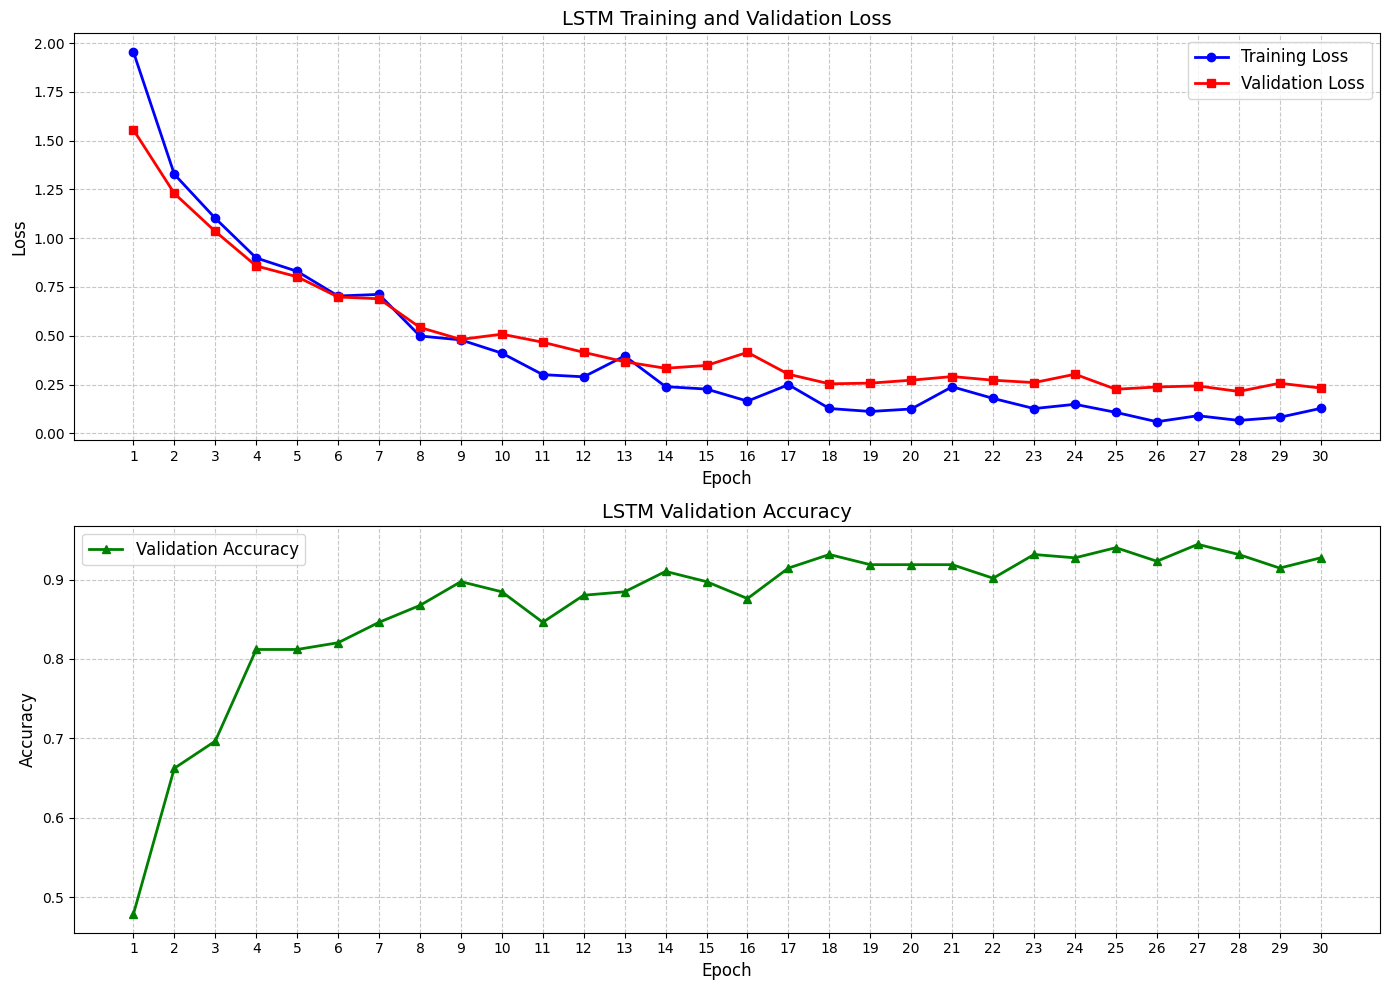

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extracted data from the log
epochs = list(range(1, 31))
train_loss = [
    1.9548, 1.3274, 1.1018, 0.8985, 0.8300, 
    0.7036, 0.7117, 0.4987, 0.4786, 0.4107,
    0.3005, 0.2895, 0.3963, 0.2391, 0.2266,
    0.1649, 0.2490, 0.1271, 0.1119, 0.1246,
    0.2385, 0.1788, 0.1267, 0.1486, 0.1072,
    0.0593, 0.0901, 0.0660, 0.0820, 0.1276
]

val_loss = [
    1.5556, 1.2291, 1.0345, 0.8577, 0.8021,
    0.6985, 0.6894, 0.5424, 0.4810, 0.5080,
    0.4666, 0.4149, 0.3665, 0.3333, 0.3477,
    0.4147, 0.3027, 0.2536, 0.2570, 0.2722,
    0.2908, 0.2721, 0.2598, 0.3027, 0.2257,
    0.2375, 0.2427, 0.2145, 0.2565, 0.2320
]

val_acc = [
    0.4786, 0.6624, 0.6966, 0.8120, 0.8120,
    0.8205, 0.8462, 0.8675, 0.8974, 0.8846,
    0.8462, 0.8803, 0.8846, 0.9103, 0.8974,
    0.8761, 0.9145, 0.9316, 0.9188, 0.9188,
    0.9188, 0.9017, 0.9316, 0.9274, 0.9402,
    0.9231, 0.9444, 0.9316, 0.9145, 0.9274
]

# Create figure with two subplots
plt.figure(figsize=(14, 10))

# Plot 1: Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, 'b-o', linewidth=2, markersize=6, label='Training Loss')
plt.plot(epochs, val_loss, 'r-s', linewidth=2, markersize=6, label='Validation Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('LSTM Training and Validation Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(epochs)

# Plot 2: Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, val_acc, 'g-^', linewidth=2, markersize=6, label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('LSTM Validation Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(epochs)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shinobi-owl/anaconda3/envs/sem2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 0.7875
Classification Report:
               precision    recall  f1-score   support

           0     0.6250    0.9091    0.7407        22
           1     0.9825    0.9032    0.9412        62
           2     0.9474    0.9000    0.9231        20
           3     0.8966    0.6667    0.7647        39
           4     0.7895    0.8824    0.8333        51
           5     0.8438    0.6000    0.7013        45
           6     0.8182    0.4865    0.6102        37
           7     0.8947    0.8361    0.8644        61
           8     0.5714    0.6667    0.6154        30
           9     0.8750    0.9655    0.9180        29
          10     0.5246    0.8649    0.6531        37

    accuracy                         0.7875       433
   macro avg     0.7971    0.7892    0.7787       433
weighted avg     0.8166    0.7875    0.7888       433

Confusion Matrix:
 [[20  0  0  0  0  1  0  0  0  1  0]
 [ 0 56  0  0  2  0  0  0  0  0  4]
 [ 0  0 18  0  0  0  0  1  0  0  1]
 [ 3  0  0 26 

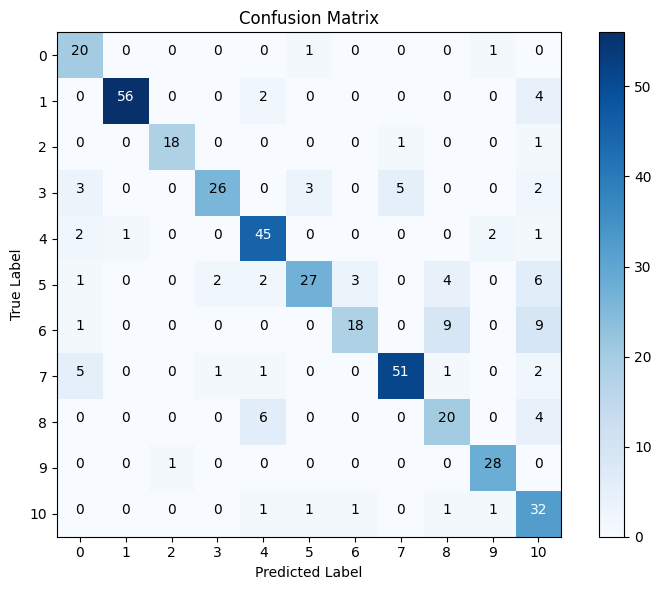

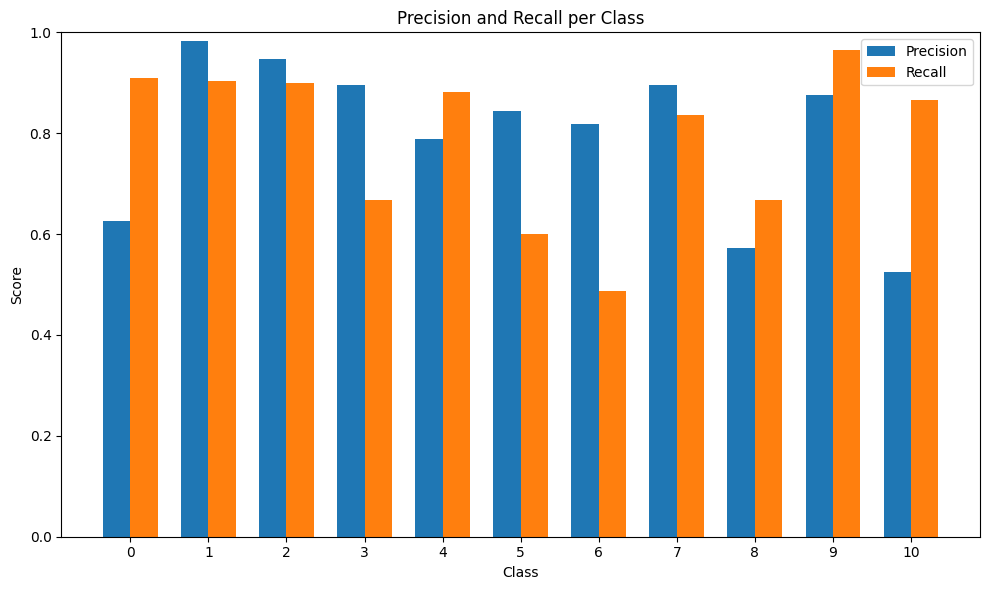

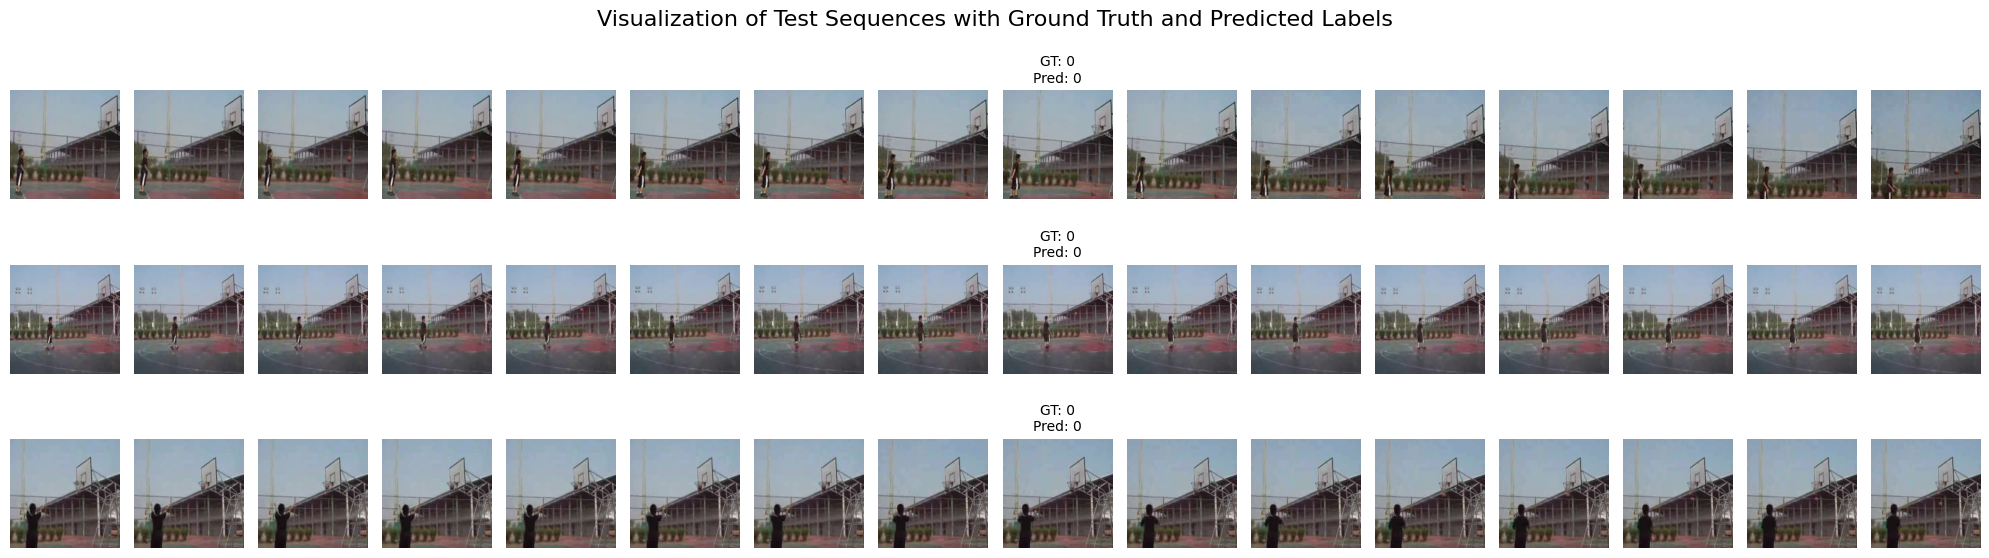

In [24]:
import torch
import cv2
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import os

# Data preprocessing (unchanged)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Hyperparameters and settings
SEQUENCE_LENGTH = 16
BATCH_SIZE = 32
HIDDEN_SIZE = 512
NUM_CLASSES = 11

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Video Dataset class
class VideoDataset(Dataset):
    def __init__(self, csv_file, transform=None, seq_length=16):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        # Read video and extract frames
        frames = self.extract_frames(video_path)
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])

        return frames, label

    def extract_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []
        
        try:
            if frame_count >= self.seq_length:
                # Take continuous clip from middle of the video
                start_idx = max(0, (frame_count - self.seq_length) // 2)
                indices = range(start_idx, start_idx + self.seq_length)
            else:
                # Take all available frames and pad with zeros
                indices = range(frame_count)
            
            # Read actual frames
            for idx in indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, (224, 224))  # Pre-resize here
                    frames.append(frame)
            
            # Pad with zeros if needed
            while len(frames) < self.seq_length:
                frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
                
        finally:
            cap.release()
        
        return np.array(frames[:self.seq_length])  # Ensure exact sequence length
    
# CNN-LSTM Model (unchanged)
class CNNLSTM(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(CNNLSTM, self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(2048, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        c_in = x.view(batch_size * seq_len, c, h, w)
        c_out = self.resnet(c_in)
        c_out = c_out.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(c_out)
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output

# --- Load Test Dataset ---
test_dataset = VideoDataset('data/test_map.csv', transform=transform, seq_length=SEQUENCE_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = CNNLSTM(HIDDEN_SIZE, NUM_CLASSES).to(device)
model.load_state_dict(torch.load('runs/last_model.pt', map_location=device))
model.eval()

# --- Evaluate on Test Data ---
all_preds = []
all_labels = []

with torch.no_grad():
    for frames, labels in test_loader:
        frames = frames.to(device)
        outputs = model(frames)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

# Compute confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)

# --- Compute per-class TP, FP, FN, Precision, and Recall ---
precisions = []
recalls = []

print("\nDetailed Analysis per Class:")
for i in range(NUM_CLASSES):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    precisions.append(precision)
    recalls.append(recall)
    print(f"Class {i}: TP={TP}, TN={TN}, FP={FP}, FN={FN}, Precision={precision:.4f}, Recall={recall:.4f}")

# --- Plot the Confusion Matrix ---
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(NUM_CLASSES)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Annotate each cell with the numeric value
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# --- Plot Precision and Recall per Class ---
classes = np.arange(NUM_CLASSES)
width = 0.35  # width of the bars

plt.figure(figsize=(10, 6))
plt.bar(classes - width/2, precisions, width, label='Precision')
plt.bar(classes + width/2, recalls, width, label='Recall')
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision and Recall per Class')
plt.xticks(classes)
plt.ylim([0, 1])
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# --- Visualization of Input Sequence ---
def unnormalize(image_tensor):
    """
    Reverse the normalization to display the image properly.
    """
    # Convert to numpy array
    image = image_tensor.cpu().numpy()
    # These mean and std values are from ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # Reverse normalization
    image = image * std[:, None, None] + mean[:, None, None]
    image = np.clip(image, 0, 1)
    return image.transpose(1, 2, 0)

# Visualize a few sequences (e.g., the first 3 examples from the test set)
num_examples = 3
plt.figure(figsize=(20, 6))

for idx in range(num_examples):
    frames, label = test_dataset[idx]
    # Add batch dimension to the sequence and predict
    input_seq = frames.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_seq)
        _, pred = torch.max(outputs.data, 1)
    predicted_label = pred.item()
    
    num_frames = frames.size(0)
    # Plot each frame of the sequence in a row corresponding to the example index
    for i in range(num_frames):
        plt.subplot(num_examples, num_frames, idx * num_frames + i + 1)
        frame_img = unnormalize(frames[i])
        plt.imshow(frame_img)
        plt.axis('off')
        # Place the label in the middle frame of the sequence
        if i == num_frames // 2:
            plt.title(f"GT: {label}\nPred: {predicted_label}", fontsize=10)

plt.suptitle("Visualization of Test Sequences with Ground Truth and Predicted Labels", fontsize=16)
plt.tight_layout()
plt.show()
